## LGBM Baseline

In [1]:
import pandas as pd
import os
import random
import warnings
import lightgbm as lgb
from wandb.lightgbm import wandb_callback
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
import random
from matplotlib import pylab as plt
from lgbm_function import inference, set_params, custom_train_test_split
from feature_engineering import feature_engineering_sun
from bayes_opt import BayesianOptimization
from datetime import datetime
import wandb
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

%matplotlib inline
warnings.filterwarnings('ignore')

### Data Load & Preprocessing
- validation data answer의 정보가 모델에 학습되는 것을 방지
- inference 단계와 동일하게 user mean을 기준으로 random하게 값을 지정
- train할 때 마지막 random하게 지정한 값은 제외
- test, validation의 마지막 값을 제외한 모든 행을 학습에 사용

In [2]:
data_dir = '/opt/ml/input/data/train_dataset'
train_csv_file_path = os.path.join(data_dir, 'train_data.csv')
train_df = pd.read_csv(train_csv_file_path, parse_dates=['Timestamp'])
train_df["next_userID"] = train_df['userID'].shift(-1)
train_df["is_test_data"] = False
print(train_df.shape)
train_df.head(5)

(2266586, 8)


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,next_userID,is_test_data
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,False
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.0,False
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.0,False
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.0,False
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.0,False


In [3]:
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, parse_dates=['Timestamp'])
test_df = test_df[test_df["answerCode"] > -1]
test_df["next_userID"] = test_df['userID'].shift(-5)
test_df["is_test_data"] = test_df[["userID", "next_userID"]].apply(lambda data: False if data["userID"] == data["next_userID"] else True, axis=1)
print(test_df.shape)
test_df.head(5)

(259370, 8)


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,next_userID,is_test_data
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,3.0,False
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,3.0,False
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,3.0,False
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3.0,False
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,3.0,False


In [4]:
df = pd.concat([train_df, test_df], ignore_index=True)
del(train_df)
del(test_df)
df.shape

(2525956, 8)

In [5]:
%%time
def random_answering(data):
    if data["is_test_data"]:
        return 1 if random.random() < 0.5 else 0
    else:
        return data["answerCode"]

df["answercode"] = df.apply(random_answering, axis=1)

CPU times: user 43.2 s, sys: 836 ms, total: 44 s
Wall time: 44.1 s


### Feature Engineering

In [6]:
%%time
df = feature_engineering_sun(df)
df.head(2)

Timestamp 관련 feature
assessmentItemID 관련 feature
KnowledgeTag별 누적 풀이 수, 정답 수, 정답률
userID, KnowledgeTag별 누적 풀이 수, 정답 수, 정답률
assessmentItemID별 누적 풀이 수, 정답 수, 정답률
question class별 누적 풀이 수, 정답 수, 정답률
userID_question_class별 누적 풀이 수, 정답 수, 정답률
question num별 누적 풀이 수, 정답 수, 정답률
userID_question_num별 누적 풀이 수, 정답 수, 정답률
user 별 누적 풀이 수, 정답 수, 정답률
userID별 timestamp 중앙값


100%|██████████| 2525956/2525956 [00:55<00:00, 45765.68it/s]


문제별 풀이 시간의 중앙값&평균값
userID별 정답률(user_acc)의 이동 평균 및 중앙값
5


100%|██████████| 2525956/2525956 [00:55<00:00, 45293.70it/s]


10


100%|██████████| 2525956/2525956 [00:56<00:00, 44982.34it/s]


15


100%|██████████| 2525956/2525956 [00:58<00:00, 43198.60it/s]


30


100%|██████████| 2525956/2525956 [00:59<00:00, 42402.29it/s]


feature_dimension_reduction
lda
svd
User가 해당 문제를 풀어본 경험 Feature
User가 해당 test를 풀어본 경험 Feature
CPU times: user 17min 58s, sys: 2min 32s, total: 20min 31s
Wall time: 19min 41s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,next_userID,is_test_data,answercode,year,...,userID_KnowledgeTag_svd,assessmentItemID_svd,question_class_svd,userID_question_class_svd,question_num_svd,userID_question_num_svd,userID_svd,all_data_svd,userID_assessmentItemID_experience,userID_testid_experience
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,False,1,2020,...,0.0,225.635792,39868.971351,0.000000,55488.827014,0.0,0.000000,68304.216652,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.0,False,1,2020,...,0.0,223.963244,39870.359260,1.395334,54423.735554,0.0,1.392196,67470.716893,0,1


In [7]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'next_userID', 'is_test_data', 'answercode', 'year',
       'month', 'question_num', 'question_class', 'KnowledgeTag_total_answer',
       'KnowledgeTag_correct_answer', 'KnowledgeTag_acc',
       'userID_KnowledgeTag_total_answer',
       'userID_KnowledgeTag_correct_answer', 'userID_KnowledgeTag_acc',
       'assessmentItemID_total_answer', 'assessmentItemID_correct_answer',
       'assessmentItemID_acc', 'question_class_correct_answer',
       'question_class_total_answer', 'question_class_acc',
       'userID_question_class_total_answer',
       'userID_question_class_correct_answer', 'userID_question_class_acc',
       'question_num_correct_answer', 'question_num_total_answer',
       'question_num_acc', 'userID_question_num_total_answer',
       'userID_question_num_correct_answer', 'userID_question_num_acc',
       'userID_correct_answer', 'userID_total_answer', 'userID_acc',
       

In [8]:
new_df = df.shift(1)
new_df.columns = ["pred_" + i for i in new_df.columns]
final_df = pd.concat([df, new_df], axis=1)

del(new_df)
del(df)

final_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,next_userID,is_test_data,answercode,year,...,pred_userID_KnowledgeTag_svd,pred_assessmentItemID_svd,pred_question_class_svd,pred_userID_question_class_svd,pred_question_num_svd,pred_userID_question_num_svd,pred_userID_svd,pred_all_data_svd,pred_userID_assessmentItemID_experience,pred_userID_testid_experience
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,False,1,2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.0,False,1,2020,...,0.000000,225.635792,39868.971351,0.000000,55488.827014,0.000000,0.000000,68304.216652,0.0,0.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.0,False,1,2020,...,0.000000,223.963244,39870.359260,1.395334,54423.735554,0.000000,1.392196,67470.716893,0.0,1.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.0,False,1,2020,...,1.471256,220.618148,39871.747169,2.788897,53791.418093,0.000000,2.783401,66968.120221,0.0,1.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.0,False,1,2020,...,2.865134,225.635792,39873.135078,4.182461,52641.660567,0.000000,4.174606,66053.545087,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,7441.0,False,0,2020,...,3.025986,106.779681,112921.194514,3.028496,148815.437899,0.000000,3.036800,186821.500958,0.0,1.0
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,7441.0,False,1,2020,...,3.822695,98.974257,112922.024215,3.845519,141310.766711,0.000000,3.859350,180846.830330,0.0,1.0
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,7441.0,False,1,2020,...,0.000000,117.348169,219522.603095,0.000000,309990.171028,0.810791,4.681933,379630.758839,0.0,0.0
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,7441.0,False,1,2020,...,1.471256,116.233111,219523.991004,1.395334,305243.442158,0.810791,6.073270,375852.292570,0.0,1.0


In [9]:
FEATS = ['assessmentItemID_acc', 'assessmentItemID_correct_answer', 'assessmentItemID_total_answer',
         'userID_question_class_acc', 'userID_question_class_correct_answer', 'userID_question_class_total_answer',
         'question_class_acc', 'question_class_correct_answer', 'question_class_total_answer',
         'userID_testid_experience', 'userID_assessmentItemID_experience',
         'assessmentItemID_lda', 'userID_question_class_lda', 'question_class_lda', 'question_num_lda', 'userID_lda', 
         'KnowledgeTag_lda', 'userID_KnowledgeTag_lda', 'all_data_lda',
         'assessmentItemID_svd', 'userID_question_class_svd', 'question_class_svd', 'question_num_svd', 'userID_svd', 
         'KnowledgeTag_svd', 'userID_KnowledgeTag_svd', 'all_data_svd',
         'userID_elapsed_median_rolling_5', 'userID_elapsed_median_rolling_10',
         'userID_elapsed_median_rolling_15', 'userID_elapsed_median_rolling_30',
         'assessmentItemID', 'testId', 'question_class', 'question_num', 'userID', 'KnowledgeTag']

### Training

In [10]:
%%time
# 유저별 분리
train_lst, test_lst = custom_train_test_split(final_df)

CPU times: user 15.5 s, sys: 18.8 s, total: 34.3 s
Wall time: 34.3 s


{'boosting_type': 'dart', 'learning_rate': 0.05, 'objective': 'binary', 'metric': 'auc', 'num_iterations': 100, 'max_depth': -1, 'num_leaves': 127, 'min_data_in_leaf': 100, 'max_bin': 256, 'bagging_fraction': 0.7, 'feature_fraction': 0.7, 'lambda_l1': 0.1, 'lambda_l2': 0.1}

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0 번째 fold
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
train, test shape
(2524526, 135) (1430, 135)



wandb: Currently logged in as: sunnight9507 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Info] Number of positive: 1652912, number of negative: 871614
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.588170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25009
[LightGBM] [Info] Number of data points in the train set: 2524526, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654742 -> initscore=0.639947
[LightGBM] [Info] Start training from score 0.639947
[100]	training's auc: 0.848456	valid_1's auc: 0.800057
VALID AUC : 0.8000565033823552 ACC : 0.727972027972028



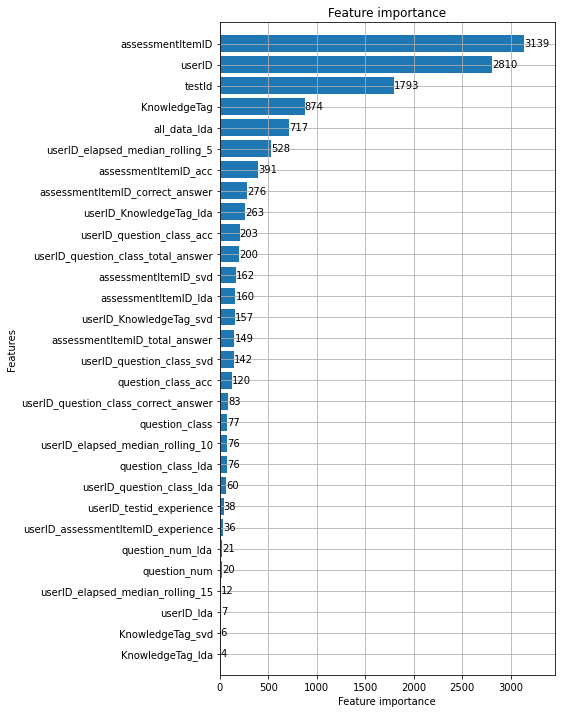

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0 번째 fold
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
train, test shape
(2524412, 135) (1544, 135)



training_auc,0.84846
valid_1_auc,0.80006
_runtime,101
_timestamp,1624123479
_step,99


training_auc,▁▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
valid_1_auc,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Info] Number of positive: 1652830, number of negative: 871582
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.483986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24994
[LightGBM] [Info] Number of data points in the train set: 2524412, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654739 -> initscore=0.639934
[LightGBM] [Info] Start training from score 0.639934
[100]	training's auc: 0.848449	valid_1's auc: 0.804981
VALID AUC : 0.8049809663840158 ACC : 0.7299222797927462



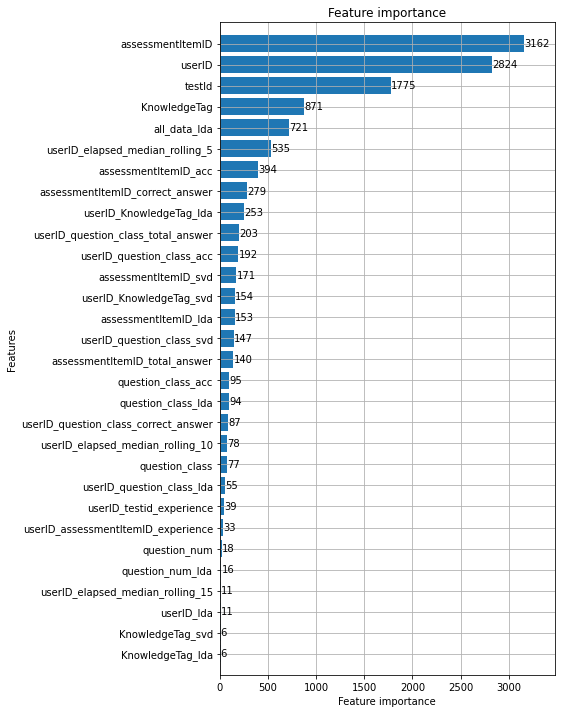

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0 번째 fold
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
train, test shape
(2524490, 135) (1466, 135)



training_auc,0.84845
valid_1_auc,0.80498
_runtime,100
_timestamp,1624123590
_step,99


training_auc,▁▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
valid_1_auc,▁▂▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Info] Number of positive: 1652874, number of negative: 871616
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.543932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25000
[LightGBM] [Info] Number of data points in the train set: 2524490, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654736 -> initscore=0.639922
[LightGBM] [Info] Start training from score 0.639922
[100]	training's auc: 0.848478	valid_1's auc: 0.813116
VALID AUC : 0.8131155387686989 ACC : 0.732605729877217



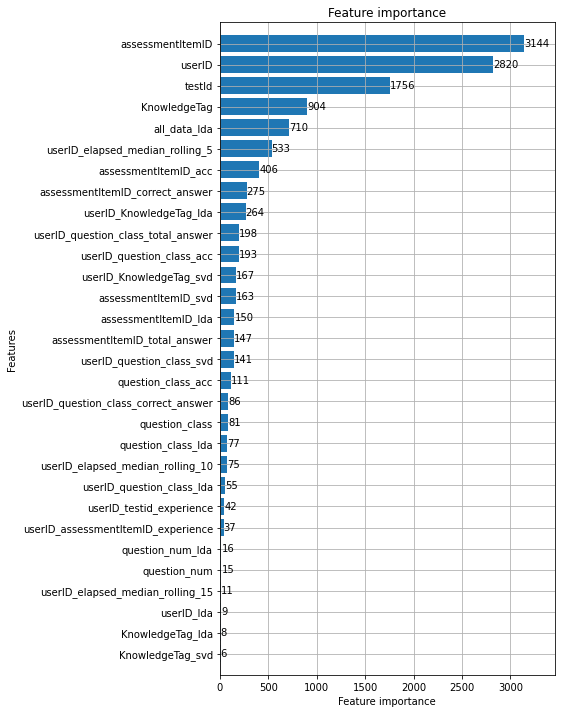

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0 번째 fold
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
train, test shape
(2524448, 135) (1508, 135)



training_auc,0.84848
valid_1_auc,0.81312
_runtime,104
_timestamp,1624123704
_step,99


training_auc,▁▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
valid_1_auc,▁▂▃▄▄▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇██████████████████
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Info] Number of positive: 1652870, number of negative: 871578
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.425213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25008
[LightGBM] [Info] Number of data points in the train set: 2524448, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654745 -> initscore=0.639963
[LightGBM] [Info] Start training from score 0.639963
[100]	training's auc: 0.848424	valid_1's auc: 0.837722
VALID AUC : 0.8377216952857799 ACC : 0.7672413793103449



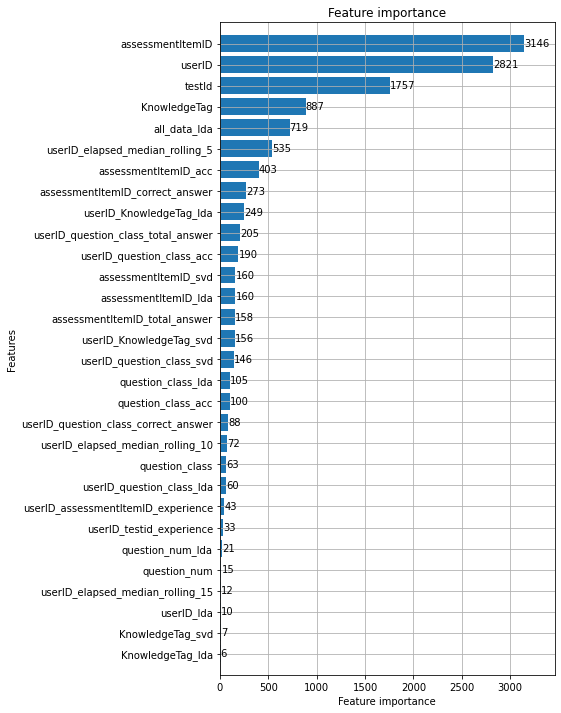

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
0 번째 fold
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
train, test shape
(2524466, 135) (1490, 135)



training_auc,0.84842
valid_1_auc,0.83772
_runtime,101
_timestamp,1624123815
_step,99


training_auc,▁▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
valid_1_auc,▁▄▄▅▄▄▆▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[LightGBM] [Info] Number of positive: 1652841, number of negative: 871625
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.599690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24994
[LightGBM] [Info] Number of data points in the train set: 2524466, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654729 -> initscore=0.639892
[LightGBM] [Info] Start training from score 0.639892
[100]	training's auc: 0.848487	valid_1's auc: 0.809136
VALID AUC : 0.8091360507079913 ACC : 0.723489932885906



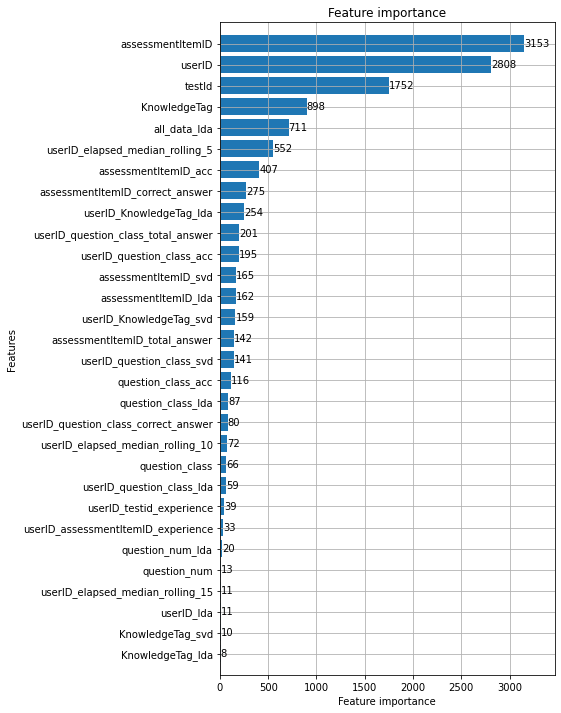

In [11]:
# # Best features
# FEATS = ['assessmentItemID_acc', 'assessmentItemID_correct_answer', 'assessmentItemID_total_answer',
#          'userID_question_class_acc', 'userID_question_class_correct_answer', 'userID_question_class_total_answer',
#          'question_class', 'userID', 'assessmentItemID']

# def learning_rate_decay(current_iter):
#     lr = 1e-1 * (.999 ** (current_iter % 50))
#     return lr

# set parameters
params = set_params()

for fold_num, (train_df, test_df) in enumerate(zip(train_lst, test_lst)):
    fold_num = 0
    print("@"*50)
    print(fold_num, "번째 fold")
    print("@"*50)

    # X, y 값 분리
    y_train = train_df["answerCode"]
    train = train_df.drop(["answerCode"], axis=1)

    y_test = test_df["answerCode"]
    test = test_df.drop(["answerCode"], axis=1)

    print("="*30)
    print("train, test shape")
    print(train.shape, test.shape)
    print("="*30)
    print()

    lgb_train = lgb.Dataset(train[FEATS], y_train)
    lgb_test = lgb.Dataset(test[FEATS], y_test)

    now = datetime.now()
    wandb.init(project='P4-DKT', config=params, entity="team-ikyo")
    wandb.run.name = "sun-lgbm-fold" + str(fold_num) + " time: " + " ".join(map(str, [now.month, now.day, now.hour, now.minute]))

    # train
    model = lgb.train(params,
                      lgb_train,
                      valid_sets = [lgb_train, lgb_test],
                      verbose_eval = 100,
                      callbacks=[wandb_callback()])
                     # lgb.reset_parameter(learning_rate = learning_rate_decay)])

    preds = model.predict(test[FEATS])
    acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_test, preds)

    print(f'VALID AUC : {auc} ACC : {acc}\n')

    # show feature importance
    fig, ax = plt.subplots(figsize=(6,12))
    lgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
    plt.show()

### Permutation importance

In [12]:
def permutation_importance(model, X_val, y_val, metric, threshold=0.001, minimize=True, verbose=True):
    results = {}
    
    y_pred = model.predict(X_val)
    
    results['base_score'] = metric(y_val, y_pred)
    if verbose:
        print(f'Base score {results["base_score"]:.5}')

    for col in X_val.columns:
        if col in ['assessmentItemID', 'testId', 'question_class', 'question_num', 'userID', 'KnowledgeTag']:
            continue
        
        freezed_col = X_val[col].copy()

        X_val[col] = np.random.permutation(X_val[col])
        
        preds = model.predict(X_val)
        results[col] = metric(y_val, preds)

        X_val[col] = freezed_col
        
        if verbose:
            print(f'column: {col} - {results[col]:.5}')
    
    if minimize:
        bad_features = [k for k in results if results[k] < results['base_score'] + threshold]
    else:
        bad_features = [k for k in results if results[k] > results['base_score'] - threshold]
    bad_features.remove('base_score')
    
    return results, bad_features

In [13]:
results, bad_features = permutation_importance(model, test[FEATS], y_test, roc_auc_score, minimize=False)

Base score 0.80914
column: assessmentItemID_acc - 0.80782
column: assessmentItemID_correct_answer - 0.80947
column: assessmentItemID_total_answer - 0.80899
column: userID_question_class_acc - 0.80577
column: userID_question_class_correct_answer - 0.8078
column: userID_question_class_total_answer - 0.80901
column: question_class_acc - 0.80777
column: question_class_correct_answer - 0.80914
column: question_class_total_answer - 0.80914
column: userID_testid_experience - 0.80914
column: userID_assessmentItemID_experience - 0.8089
column: assessmentItemID_lda - 0.80734
column: userID_question_class_lda - 0.80877
column: question_class_lda - 0.80767
column: question_num_lda - 0.80914
column: userID_lda - 0.80905
column: KnowledgeTag_lda - 0.80907
column: userID_KnowledgeTag_lda - 0.80394
column: all_data_lda - 0.62124
column: assessmentItemID_svd - 0.80932
column: userID_question_class_svd - 0.8087
column: question_class_svd - 0.80914
column: question_num_svd - 0.80914
column: userID_svd - 

In [14]:
bad_features

['assessmentItemID_correct_answer',
 'assessmentItemID_total_answer',
 'userID_question_class_total_answer',
 'question_class_correct_answer',
 'question_class_total_answer',
 'userID_testid_experience',
 'userID_assessmentItemID_experience',
 'userID_question_class_lda',
 'question_num_lda',
 'userID_lda',
 'KnowledgeTag_lda',
 'assessmentItemID_svd',
 'userID_question_class_svd',
 'question_class_svd',
 'question_num_svd',
 'userID_svd',
 'KnowledgeTag_svd',
 'all_data_svd',
 'userID_elapsed_median_rolling_10',
 'userID_elapsed_median_rolling_15',
 'userID_elapsed_median_rolling_30']

In [15]:
new_FEATS = list(set(FEATS) - set(bad_features))

new_FEATS

['userID_question_class_correct_answer',
 'userID_elapsed_median_rolling_5',
 'question_class',
 'assessmentItemID_lda',
 'userID_question_class_acc',
 'question_class_acc',
 'question_class_lda',
 'testId',
 'all_data_lda',
 'assessmentItemID_acc',
 'assessmentItemID',
 'userID_KnowledgeTag_lda',
 'KnowledgeTag',
 'userID',
 'question_num',
 'userID_KnowledgeTag_svd']

### AutoML

In [16]:
def train_optuna(num_leaves, min_data_in_leaf, max_bin, bagging_fraction, feature_fraction, lambda_l1, lambda_l2,
                 train_df=train_df):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=2021)
    
    params = {}
    params["boosting_type"] = "dart" # gbdt, dart, goss
    params["learning_rate"] = 5e-2 # 1e-1, 5e-2, 1e-2, 5e-3, 1e-3
    params["objective"] = "binary"
    params["metric"] = "auc" # binary_logloss, rmse, huber, auc
    params["num_iterations"] = 10 # 100
    params["max_depth"] = -1 # -1
    params["num_leaves"] = int(num_leaves) # 31 이상적으로 num_leaves값은 2 ^ (max_depth) 값보다 적거나 같아야 합니다.
    params["min_data_in_leaf"] = int(min_data_in_leaf) # 20 100 ~ 1000 수백 또는 수천 개로 정하는 것
    params["max_bin"] = int(max_bin) # 256
    params["bagging_fraction"] = bagging_fraction # 1.0
    params["feature_fraction"] = feature_fraction # 1.0
    params["lambda_l1"] = lambda_l1 # 0.0
    params["lambda_l2"] = lambda_l2 # 0.0
    params["random_state"] = 2021

    auc_score = 0
    
    print("@"*50)
    print("start")
    print("@"*50)

    for fold, (train_index, test_index) in enumerate(skf.split(train_df, train_df["answerCode"])):
        temp_train = train_df.iloc[train_index,:]
        temp_valid = train_df.iloc[test_index,:]
        
        y_train = train_df["answerCode"].iloc[train_index]
        y_test = train_df["answerCode"].iloc[test_index]
        
        lgb_train = lgb.Dataset(temp_train[new_FEATS], y_train)
        lgb_test = lgb.Dataset(temp_valid[new_FEATS], y_test)

        # train
        model = lgb.train(params,
                          lgb_train,
                          valid_sets = [lgb_train, lgb_test],
                          verbose_eval = 100,
                          callbacks=[wandb_callback()])
        
        
        preds = model.predict(temp_valid[new_FEATS])
        acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
        auc = roc_auc_score(y_test, preds)

        auc_score += auc

    print(auc_score / 5)
    return auc_score / 5

In [17]:
lgbm_bo = BayesianOptimization(train_optuna, {'num_leaves': (16, 512),
                                              'min_data_in_leaf': (20, 1000),
                                              'max_bin': (10, 256),
                                              'bagging_fraction': (0.5, 1),
                                              'feature_fraction': (0.5, 1),
                                              'lambda_l1' : (0, 10),
                                              'lambda_l2' : (0, 10)})

In [18]:
lgbm_bo.maximize(init_points=2, n_iter=10, acq='ei')

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 |  max_bin  | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
start
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
[LightGBM] [Info] Number of positive: 1101894, number of negative: 581083
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19315
[LightGBM] [Info] Number of data points in the train set: 1682977, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654729 -> initscore=0.639892
[LightGBM] [Info] Start training from score 0.639892
[LightGBM] [Info] Number of positive: 1101894, number of negative: 581083
[LightGBM] [Warning] Auto-choosin

### Inference

In [19]:
total_preds = model.predict(test[FEATS])

# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, f"output" + "_".join(map(str, [now.month, now.day, now.hour, now.minute])) +  ".csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/output6_19_17_30.csv
